In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
plt.rcParams['figure.figsize'] = [12,10]

[19.95262315 23.26305067 27.12272579 31.6227766  36.86945065 42.98662347
 50.11872336 58.43414134 68.12920691 79.43282347]


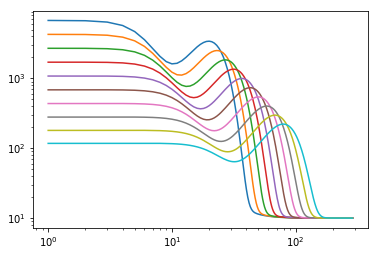

In [74]:
npts = 288
f = np.linspace(1, 288, npts)
def harvey(f, a, b, c):
    return a**2/b / (1 + (f/b)**c)
def gaussian(f, nu, sig, height):
    return height / (2 * np.pi)**0.5 / sig * np.exp(-0.5 * (f - nu)**2 / sig**2)
def model(f, numax, white):
    h = harvey(f, 4e3/10**numax, 10**numax*0.3, 4.0)
    g = gaussian(f, 10**numax, 10**numax*0.3, 1e6/10**numax)
    return h + g + white
numaxs = np.linspace(1.3, 1.9, 10)
p = np.zeros([len(f), len(numaxs)])
fig, ax = plt.subplots()
for i in range(len(numaxs)):
    p[:,i] = model(f, numaxs[i], 10.0) #* np.random.chisquare(2, npts)/2
    ax.plot(f, p[:,i])
data = p * np.random.chisquare(2, [npts, len(numaxs)])/2
logg_nmx = numaxs + np.random.randn(len(numaxs))*0.01
ax.set_yscale('log')
ax.set_xscale('log')
print(10**numaxs)

In [ ]:
code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return a^2/b/(1 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
}
data {
    int<lower = 0> N;
    int<lower = 0> M;
    vector[N] f;
    real<lower = 0> p[N, M];
    vector[M] numax_est;
}
parameters {
    real<lower = 1.0, upper = 2.4> numaxs[M];
    real<lower = 0, upper = 3> white[M];
    real<lower = 0, upper = 5> ahs[M];
    real<lower = 2, upper = 4> ah;
    real<lower = 0.1, upper = 0.6> bh;
    real<lower = 0.1, upper = 0.6> wh;
    real<lower = 0, upper = 8> hh;
    real<lower = 0, upper = 1.0> sigma_w;
    real<lower = 0, upper = 1.0> sigma_n;
    real<lower = 0, upper = 1.0> sigma_ah;
}
transformed parameters{
    real numax[M];
    for (i in 1:M)
        numax[i] = 10^numaxs[i];
}
model {
    real tmp[N, M];
    for (j in 1:M){
        for (i in 1:N){
            tmp[i,j] = 0.5 / (gaussian(f[i], numax[j], numax[j] * wh, (10^hh)/numax[j]) 
                        + harvey(f[i], 10^ahs[j] / numax[j], numax[j] * bh, 4.0) + 10^white[j]);
        }
        p[1:N, j] ~ gamma(1, tmp[1:N, j]);
    }    
    hh ~ normal(6, 0.5);
    ahs ~ normal(ah, sigma_ah);
    ah ~ normal(3.4, 0.5);
    sigma_ah ~ normal(0.0, 0.3);
    wh ~ normal(0.3, 0.1);
    bh ~ normal(0.3, 0.1);
    white ~ normal(1.0, sigma_w);
    sigma_w ~ normal(0.0, 0.3);
    numaxs ~ normal(numax_est, sigma_n);
    sigma_n ~ normal(0.0, 0.3);
}
'''
sm = pystan.StanModel(model_code=code, model_name='backfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_fad0dbbf784dcffe3f12037d6b28277b NOW.


In [ ]:
dat = {'N': len(f),
       'M': len(numaxs),
      'f': f,
      'p': data,
      'numax_est': logg_nmx}
fit = sm.sampling(data=dat, iter=4000, chains=2)
fit.plot()

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
print(fit)